<a href="https://colab.research.google.com/github/hetanshipatel/real-time-stock-price-prediction/blob/main/notebooks/data_collection_eda_feature_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **📈 End-to-End Stock Price Prediction Pipeline**

This notebook performs an end-to-end stock market analysis and prediction workflow.  
Users can input **any stock ticker**, fetch historical and market data, perform feature engineering, and build a machine learning model to predict future stock prices.

The pipeline includes:
- Data fetching
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model-ready dataset creation




## 1️⃣ Import Required Libraries

We import all the necessary libraries for:
- Fetching stock and market data
- Data manipulation
- Visualization
- Date handling

This ensures the notebook is self-contained and reproducible.


In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## 2️⃣ User Input: Stock Ticker & Start Date

This project is **not limited to a fixed stock**.  
The user can input:
- Any stock ticker (e.g., NVDA, AAPL, TSLA)
- A start date for historical data

This makes the pipeline reusable and scalable.


In [2]:
STOCK_TICKER = input("Enter stock ticker (e.g., AAPL, TSLA): ").upper()
START_DATE = input("Enter start date: ")

Enter stock ticker (e.g., AAPL, TSLA): TSLA
Enter start date: 2001-01-01


## 3️⃣ Fetch Historical Stock Price Data

We fetch historical OHLCV (Open, High, Low, Close, Volume) data using Yahoo Finance.

A validation check is included to ensure:
- The ticker is valid
- Data exists for the given period


In [3]:
stock_df = yf.Ticker(STOCK_TICKER).history(start=START_DATE)

if stock_df.empty:
    raise ValueError("Invalid ticker or no data found")

stock_df.reset_index(inplace=True)
stock_df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


## 4️⃣ Fetch External Market Indicators

Stock prices are influenced by broader market conditions.  
To avoid relying only on historical prices, we also fetch:

- S&P 500 (Market performance)
- NASDAQ (Tech-heavy index)
- VIX (Market volatility / fear index)
- US 10-Year Treasury Yield (Interest rate proxy)

These features help the model learn macro-level influences.


In [4]:
external_tickers = {
    "SP500": "^GSPC",
    "NASDAQ": "^IXIC",
    "VIX": "^VIX",
    "US10Y": "^TNX"
}

external_dfs = []

for name, ticker in external_tickers.items():
    df_ext = yf.Ticker(ticker).history(start=START_DATE)[["Close"]]
    df_ext = df_ext.rename(columns={"Close": name})
    df_ext.reset_index(inplace=True)
    external_dfs.append(df_ext)


## 5️⃣ Merge Stock Data with External Indicators

All external market datasets are merged with the stock data using the date column.

This creates a **single unified dataset** containing:
- Stock-level data
- Market-level signals


In [5]:
df = stock_df.copy()

for ext_df in external_dfs:
    df = pd.merge(df, ext_df, on="Date", how="left")

df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SP500,NASDAQ,VIX,US10Y
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,1041.239990,2135.179932,NaN,NaN
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,1030.709961,2109.239990,NaN,NaN
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,1027.369995,2101.360107,NaN,NaN
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,1022.580017,2091.790039,NaN,NaN
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,1028.060059,2093.879883,NaN,NaN


## 6️⃣ Save Raw Dataset

The combined dataset is saved as a CSV file with:
- Stock ticker
- Current date

This allows:
- Reproducibility
- Offline analysis
- Easy reuse in other models or dashboards


In [6]:
today = datetime.today().strftime("%Y-%m-%d")
file_name = f"{STOCK_TICKER}_raw_data_{today}.csv"
df.to_csv(file_name, index=False)
file_name

'TSLA_raw_data_2026-01-21.csv'

In [7]:
#from google.colab import files
#files.download(file_name)

## 7️⃣ Closing Price Trend

We visualize the stock’s closing price over time to:
- Identify long-term trends
- Observe volatility
- Understand major price movements


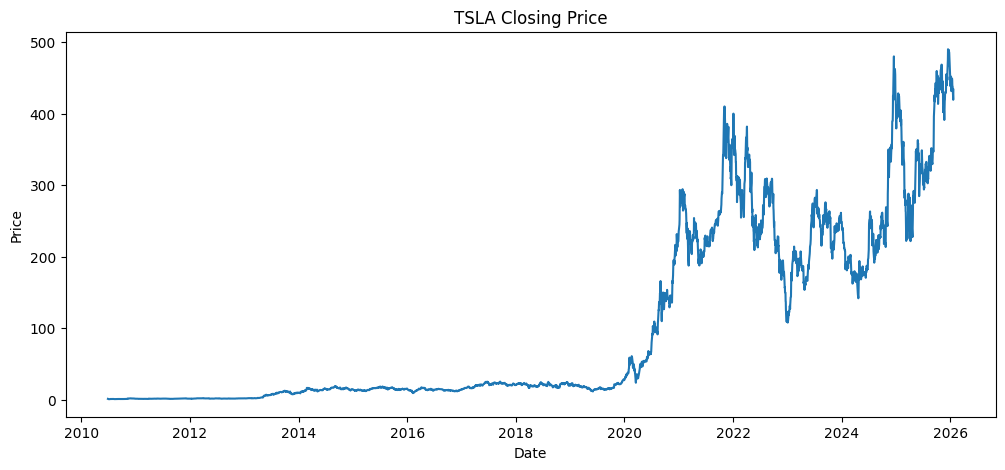

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"])
plt.title(f"{STOCK_TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## 8️⃣ Daily Return Distribution

Daily returns help understand:
- Risk
- Volatility
- Frequency of large price movements

A histogram shows how returns are distributed over time.


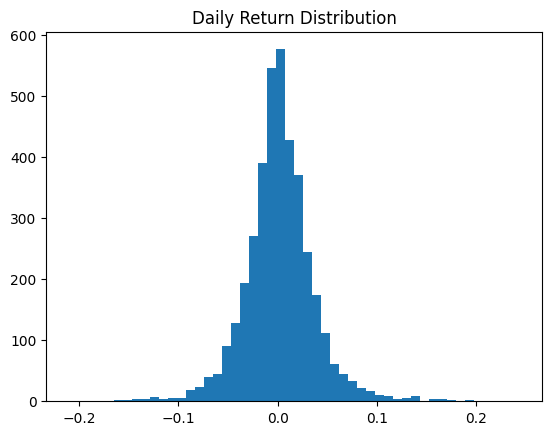

In [9]:
df["Daily_Return"] = df["Close"].pct_change()

plt.hist(df["Daily_Return"].dropna(), bins=50)
plt.title("Daily Return Distribution")
plt.show()

## 9️⃣ Feature Engineering: Price-Based Indicators

We create technical indicators derived from price data, including:
- Daily returns
- Short-term and long-term moving averages
- Rolling volatility

These features help the model detect trends and momentum.


In [10]:
df['return'] = df['Close'].pct_change()

df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['ma_50'] = df['Close'].rolling(50).mean()

df['volatility_20'] = df['return'].rolling(20).std()


## 🔟 Feature Engineering: Relative Strength Index (RSI)

RSI measures the speed and magnitude of price movements.

- RSI > 70 → Overbought
- RSI < 30 → Oversold

This indicator helps the model understand momentum-driven behavior.


In [11]:
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))


## 1️⃣1️⃣ Feature Engineering: Volume-Based Indicators

Volume often confirms price movements.

We include:
- Rolling average volume
- Percentage change in volume

These features capture unusual trading activity.


In [12]:
df['volume_ma_20'] = df['Volume'].rolling(20).mean()
df['volume_change'] = df['Volume'].pct_change()

## 1️⃣2️⃣ Market Influence Feature

We include S&P 500 returns to represent overall market direction.

This helps the model distinguish:
- Stock-specific movement
- Market-wide movement


In [13]:
import yfinance as yf

sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
df['sp500_return'] = sp500['Close'].pct_change()

/tmp/ipython-input-1712149416.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=df.index.min(), end=df.index.max())
[*********************100%***********************]  1 of 1 completed


## 1️⃣3️⃣ Data Cleaning

Rolling indicators introduce missing values.

We remove:
- Initial NaNs
- Incomplete rows

This ensures clean input for model training.


In [14]:
df.dropna(inplace=True)

In [15]:
df['target'] = df['Close'].shift(-1)
df.dropna(inplace=True)